In [1]:
%%capture
!pip install duckdb
!pip install plotnine -U

In [2]:
import sys
import os
import gc

import warnings
warnings.filterwarnings('ignore')

import random
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import duckdb

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

import shap

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
from plotnine import * 
from mizani.breaks import date_breaks
from mizani.formatters import date_format

import duckdb
duckdb.query('PRAGMA disable_progress_bar;')


RANDOM_STATE = 1966
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
seed_everything(RANDOM_STATE)

class Shhh:
    # some of these models are still quite chatty even after disabling logging
    # we use this to swallow the printed output.
    # see: https://stackoverflow.com/questions/72346178/how-to-suppress-automatically-generated-output-from-a-python-code
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr
        
%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Introduction

Rohlik Group, an e-grocery leader, is relaunching its [sales forecasting challenge](https://www.kaggle.com/competitions/rohlik-sales-forecasting-challenge-v2).

In this competition, we'll be using historical sales data to predict the next 14 days of sales for each of their warehouses.

Evaluation: Weighted Mean Absolute Error (WMAE)

Let's get started!

In [3]:
BASEPATH = '/kaggle/input/rohlik-sales-forecasting-challenge-v2/'

In [4]:
# borrowed from https://www.kaggle.com/code/samvelkoch/rohlik2-lama-v6-weighted

calendar = duckdb.query(f'''
    SELECT 
       t.* exclude(holiday_name),
       coalesce(t.holiday_name, '-') as holiday_name
    FROM 
        read_csv('{BASEPATH + 'calendar.csv'}') t
    ''').df()

from datetime import datetime
czech_holiday = [ 
    (['03/31/2024', '04/09/2023', '04/17/2022', '04/04/2021', '04/12/2020'], 'Easter Day'),#loss
    (['05/12/2024', '05/10/2020', '05/09/2021', '05/08/2022', '05/14/2023'], "Mother Day"), #loss
]
brno_holiday = [
    (['03/31/2024', '04/09/2023', '04/17/2022', '04/04/2021', '04/12/2020'], 'Easter Day'),#loss
    (['05/12/2024', '05/10/2020', '05/09/2021', '05/08/2022', '05/14/2023'], "Mother Day"), #loss
]

budapest_holidays = []
munich_holidays = [
    (['03/30/2024', '04/08/2023', '04/16/2022', '04/03/2021'], 'Holy Saturday'),#loss
    (['05/12/2024', '05/14/2023', '05/08/2022', '05/09/2021'], 'Mother Day'),#loss
]

frank_holidays = [
    (['03/30/2024', '04/08/2023', '04/16/2022', '04/03/2021'], 'Holy Saturday'),#loss
    (['05/12/2024', '05/14/2023', '05/08/2022', '05/09/2021'], 'Mother Day'),#loss
]

def fill_loss_holidays(df_fill, warehouses, holidays):
    df = df_fill.copy()
    for item in holidays:
        dates, holiday_name = item
        generated_dates = [datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d') for date in dates]
        for generated_date in generated_dates:
            df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday'] = 1
            df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday_name'] = holiday_name
    return df

calendar = fill_loss_holidays(df_fill=calendar, warehouses=['Prague_1', 'Prague_2', 'Prague_3'], holidays=czech_holiday)
calendar = fill_loss_holidays(df_fill=calendar, warehouses=['Brno_1'], holidays=brno_holiday)
calendar = fill_loss_holidays(df_fill=calendar, warehouses=['Munich_1'], holidays=munich_holidays)
calendar = fill_loss_holidays(df_fill=calendar, warehouses=['Frankfurt_1'], holidays=frank_holidays)
calendar = fill_loss_holidays(df_fill=calendar, warehouses=['Budapest_1'], holidays=budapest_holidays)

Frankfurt_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Frankfurt_1"')
Prague_2 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_2"')
Brno_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Brno_1"')
Munich_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Munich_1"')
Prague_3 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_3"')
Prague_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Prague_1"')
Budapest_1 = calendar.query('date >= "2020-08-01 00:00:00" and warehouse =="Budapest_1"')

def process_calendar(df):
    df = df.sort_values('date').reset_index(drop=True)
    df['next_holiday_date'] = df.loc[df['holiday'] == 1, 'date'].shift(-1)
    df['next_holiday_date'] = df['next_holiday_date'].bfill()
    df['days_to_holiday'] = (df['next_holiday_date'] - df['date']).dt.days
    df.drop(columns=['next_holiday_date'], inplace=True)
    df['next_shops_closed_date'] = df.loc[df['shops_closed'] == 1, 'date'].shift(-1)
    df['next_shops_closed_date'] = df['next_shops_closed_date'].bfill()
    df['days_to_shops_closed'] = (df['next_shops_closed_date'] - df['date']).dt.days
    df.drop(columns=['next_shops_closed_date'], inplace=True)
    df['day_after_closing'] = (
        (df['shops_closed'] == 0) & (df['shops_closed'].shift(1) == 1)
    ).astype(int)
    
    df['long_weekend'] = (
        (df['shops_closed'] == 1) & (df['shops_closed'].shift(1) == 1)
    ).astype(int)
    df['school'] = df['winter_school_holidays'] + df['school_holidays']
    return df
dfs = ['Frankfurt_1', 'Prague_2', 'Brno_1', 'Munich_1', 'Prague_3', 'Prague_1', 'Budapest_1']
processed_dfs = [process_calendar(globals()[df]) for df in dfs]
calendar_extended = (
    pd.concat(processed_dfs)
    .sort_values('date')
    .drop(columns=['winter_school_holidays', 'school_holidays'])
    #.query('date <= "2024-06-02"')
    .reset_index(drop=True))

In [5]:
# read and join data

duckdb.query(f'''
    create or replace table sales as
    SELECT 
        s.*,
        'train' as rowtype
    FROM 
        read_csv('{BASEPATH + 'sales_train.csv'}') s
    WHERE
        -- 52 rows have a null sales observation. 
        -- we just drop them.
        s.sales is not null
    UNION ALL BY NAME
    SELECT 
        s.*,
        'test' as rowtype
    FROM 
        read_csv('{BASEPATH + 'sales_test.csv'}') s
    ''')


duckdb.query(f'''
    create or replace table inventory as
    SELECT 
       t.* exclude(L1_category_name_en, L2_category_name_en, L3_category_name_en, L4_category_name_en),
       L1_category_name_en as l1_cat,
       L1_category_name_en || '-' ||  L2_category_name_en as l2_cat,
       L1_category_name_en || '-' ||  L2_category_name_en || '-' ||  L3_category_name_en as l3_cat,
       L1_category_name_en || '-' ||  L2_category_name_en || '-' ||  L3_category_name_en || '-' ||  L3_category_name_en as l4_cat
    FROM 
        read_csv('{BASEPATH + 'inventory.csv'}') t
    ''')

duckdb.query(f'''
    create or replace table calendar as
    SELECT 
       *
    FROM 
        calendar_extended
    ''')

duckdb.query(f'''
    create or replace table test_weights as
    SELECT 
       *
    FROM 
        read_csv('{BASEPATH + 'test_weights.csv'}') t
    ''')

duckdb.query(f'''
    create or replace view all_data as
    SELECT 
        s.*,
        c.* exclude(warehouse, date),
        i.* exclude(warehouse, unique_id),
        w.* exclude(unique_id),
        -- group into fortnights
        -- The whole of test is a single fold
        date_diff('day', '2020-07-20', s.date) // 14 as dt_fold,
        date_diff('day', '2020-07-20', s.date) % 14  as dt_fold_day,
    FROM 
        sales s
        join calendar c on c.warehouse = s.warehouse and c.date = s.date
        join inventory i on i.warehouse = s.warehouse and i.unique_id = s.unique_id
        join test_weights w on w.unique_id = s.unique_id
''')

# EDA
No nulls, lots of interesting data.

In [6]:
def round_col(x):
    x_round = np.round(pd.to_numeric(x, errors='coerce'), 1)
    x_none = x != x
    return np.where(np.isnan(x_round), np.where(x_none, '-', x), x_round)

df_summary = duckdb.query(f'''
    summarize 
    select * exclude(rowtype, dt_fold, dt_fold_day)
    from all_data 
    where rowtype = 'train' ''').df()

def disp_summary(df):
    numeric_cols = ['min', 'max', 'approx_unique', 'avg',
           'std', 'q25', 'q50', 'q75', 'count', 'null_percentage']
    result = df_summary.copy()
    for col in numeric_cols:
        result[col] = round_col(df_summary[col])

    return result.drop(columns=['count', 'null_percentage'])
        
disp_summary(df_summary)

column_name column_type  \
0              unique_id      BIGINT   
1                   date        DATE   
2              warehouse     VARCHAR   
3           total_orders      DOUBLE   
4                  sales      DOUBLE   
5        sell_price_main      DOUBLE   
6           availability      DOUBLE   
7        type_0_discount      DOUBLE   
8        type_1_discount      DOUBLE   
9        type_2_discount      DOUBLE   
10       type_3_discount      DOUBLE   
11       type_4_discount      DOUBLE   
12       type_5_discount      DOUBLE   
13       type_6_discount      DOUBLE   
14               holiday      BIGINT   
15          shops_closed      BIGINT   
16          holiday_name     VARCHAR   
17       days_to_holiday      DOUBLE   
18  days_to_shops_closed      DOUBLE   
19     day_after_closing      BIGINT   
20          long_weekend      BIGINT   
21                school      BIGINT   
22     product_unique_id      BIGINT   
23                  name     VARCHAR   
24                l1_cat     VARCHAR   
25                l2_cat     VARCHAR   
26                l3_cat     VARCHAR   
27                l4_cat     VARCHAR   
28                weight      DOUBLE   

                                              min  \
0                                             0.0   
1                                      2020-08-01   
2                                          Brno_1   
3                                           458.0   
4                                             0.0   
5                                             0.0   
6                                             0.0   
7                                           -20.9   
8                                             0.0   
9                                             0.0   
10                                            0.0   
11                                           -0.0   
12                                            0.0   
13                                           -0.8   
14                                            0.0   
15                                            0.0   
16                                              -   
17                                            1.0   
18                                            1.0   
19                                            0.0   
20                                            0.0   
21                                            0.0   
22                                            0.0   
23                                        Apple_0   
24                                         Bakery   
25                            Bakery-Bakery_L2_10   
26               Bakery-Bakery_L2_10-Bakery_L3_17   
27  Bakery-Bakery_L2_10-Bakery_L3_17-Bakery_L3_17   
28                                            0.0   

                                                  max approx_unique     avg  \
0                                              5431.0          5703  2740.8   
1                                          2024-06-02          1650       -   
2                                            Prague_3             7       -   
3                                             18475.0          8311  5995.7   
4                                             26316.2        127198   108.4   
5                                             21683.0         27860   181.4   
6                                                 1.0            88     0.9   
7                                                 1.0         13314     0.0   
8                                                 0.5           157     0.0   
9                                                 0.8          2908     0.0   
10                                                0.3            17     0.0   
11                                                0.5          1251     0.0   
12                                                0.7           677     0.0   
13                                                0.9         39761     0.0   
14                                  

Not all products are active in the test period.

In [7]:
duckdb.query(f'''
    SELECT 
       rowtype, 
       count(*) as rows, 
       min(date), max(date), 
       count(distinct(product_unique_id)), 
       count(distinct(warehouse))
    FROM 
        all_data
    GROUP BY rowtype
    ORDER By min(date)
    ''').df()


rowtype     rows  min(date)  max(date)  count(DISTINCT product_unique_id)  \
0   train  4007367 2020-08-01 2024-06-02                               2653   
1    test    47021 2024-06-03 2024-06-16                               1671   

   count(DISTINCT warehouse)  
0                          7  
1                          7

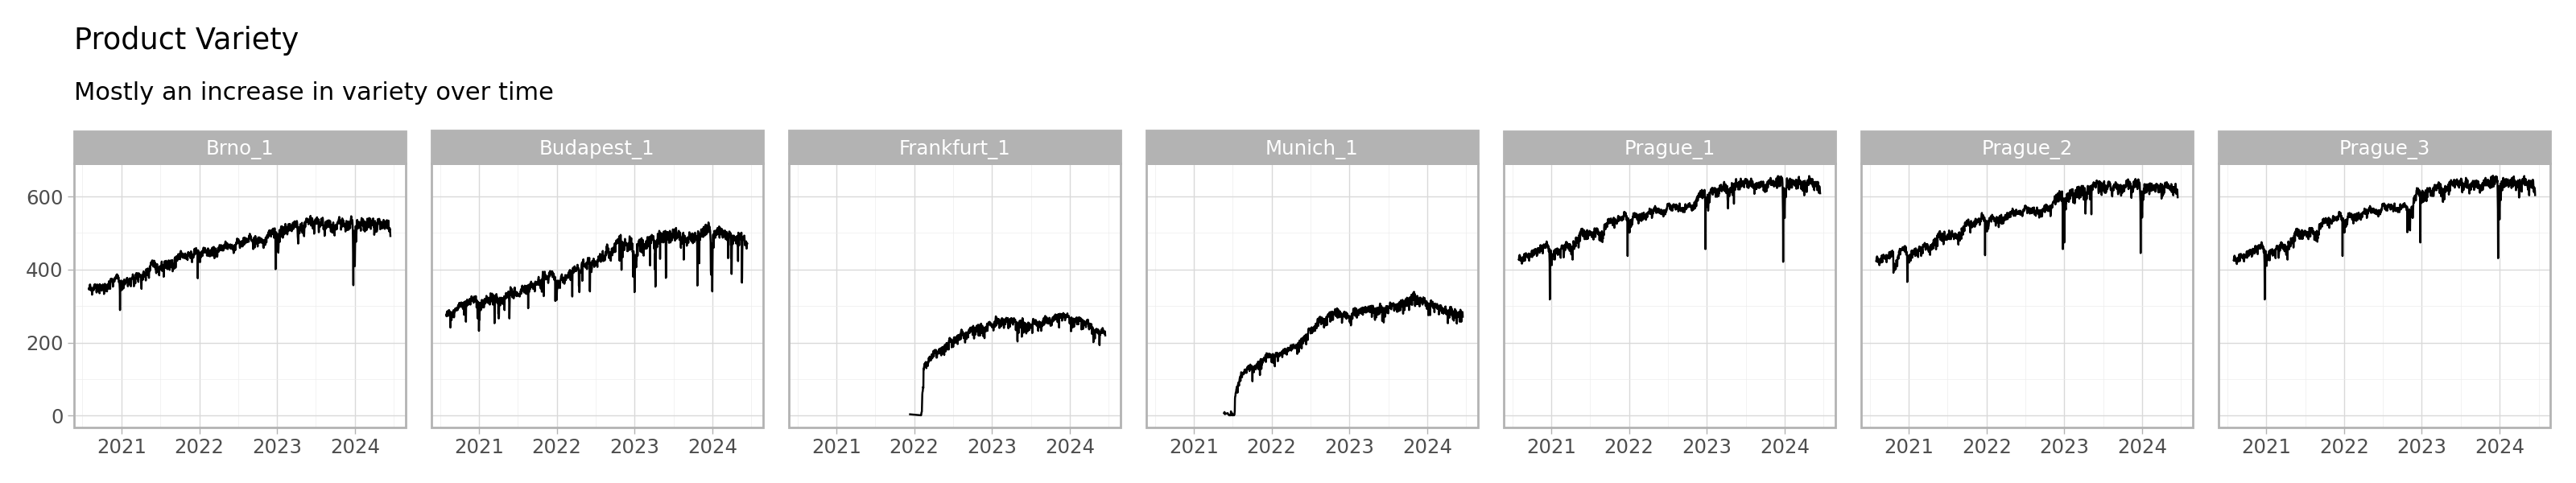

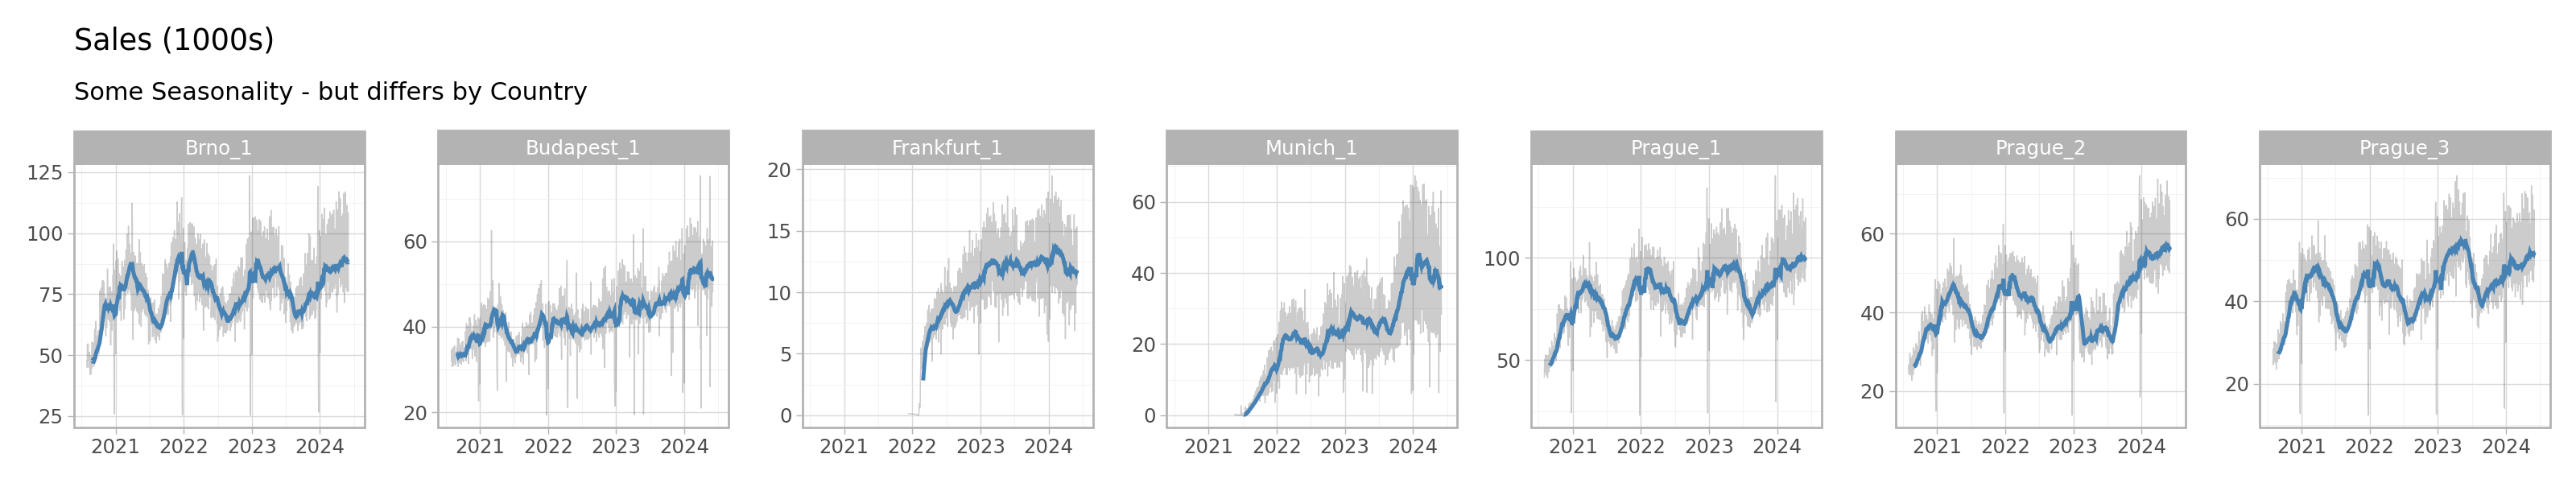

In [8]:
df_warehouse_products = duckdb.query(f'''
    SELECT 
       warehouse, date,
       count(distinct product_unique_id) as product_count,
       sum(sales) as sales
    FROM 
        all_data
    GROUP BY warehouse, date
    ''').df()

display(
    ggplot(df_warehouse_products, mapping=aes(x='date', y='product_count')) 
    + theme_light()
    + theme(figure_size=(16, 3))
    + geom_line()
    + scale_x_datetime(
        breaks=date_breaks("1 years"), labels=date_format("%Y"))
    + facet_wrap('warehouse', ncol=7)
    + labs(x='', y='', 
        title='Product Variety',
        subtitle='Mostly an increase in variety over time'))

display(
    ggplot(df_warehouse_products, mapping=aes(x='date', y='sales / 1000')) 
    + theme_light()
    + theme(figure_size=(16, 3))
    + geom_line(size=0.3, alpha=0.2)
    + scale_x_datetime(
        breaks=date_breaks("1 years"), labels=date_format("%Y"))
    + facet_wrap('warehouse', ncol=7, scales='free_y')
    + geom_smooth(method='mavg', method_args={'window': 28}, color='steelblue', se=False)
    + labs(x='', y='', 
        title='Sales (1000''s)',
        subtitle='Some Seasonality - but differs by Country'))

Top Selling Products 2024

Some fairly erratic patterns over time.

In [9]:
df_top_products = duckdb.query(f'''
    WITH sales_by_category as (
        SELECT 
           name, 
           sum(sales) as sales,
        FROM 
            all_data
        WHERE
            date >= '2024-01-01'
        GROUP BY name)
    select 
        name, 
        sales * 100 / sum(sales) over () as perc_sales
    from sales_by_category
    order by perc_sales desc
    limit 50
    ''').df()

df_top_products.head(5)

name  perc_sales
0      Roll_57    5.111109
1      Roll_51    3.970615
2  Cucumber_10    2.630528
3    Banana_10    1.516860
4    Bread_122    1.066573

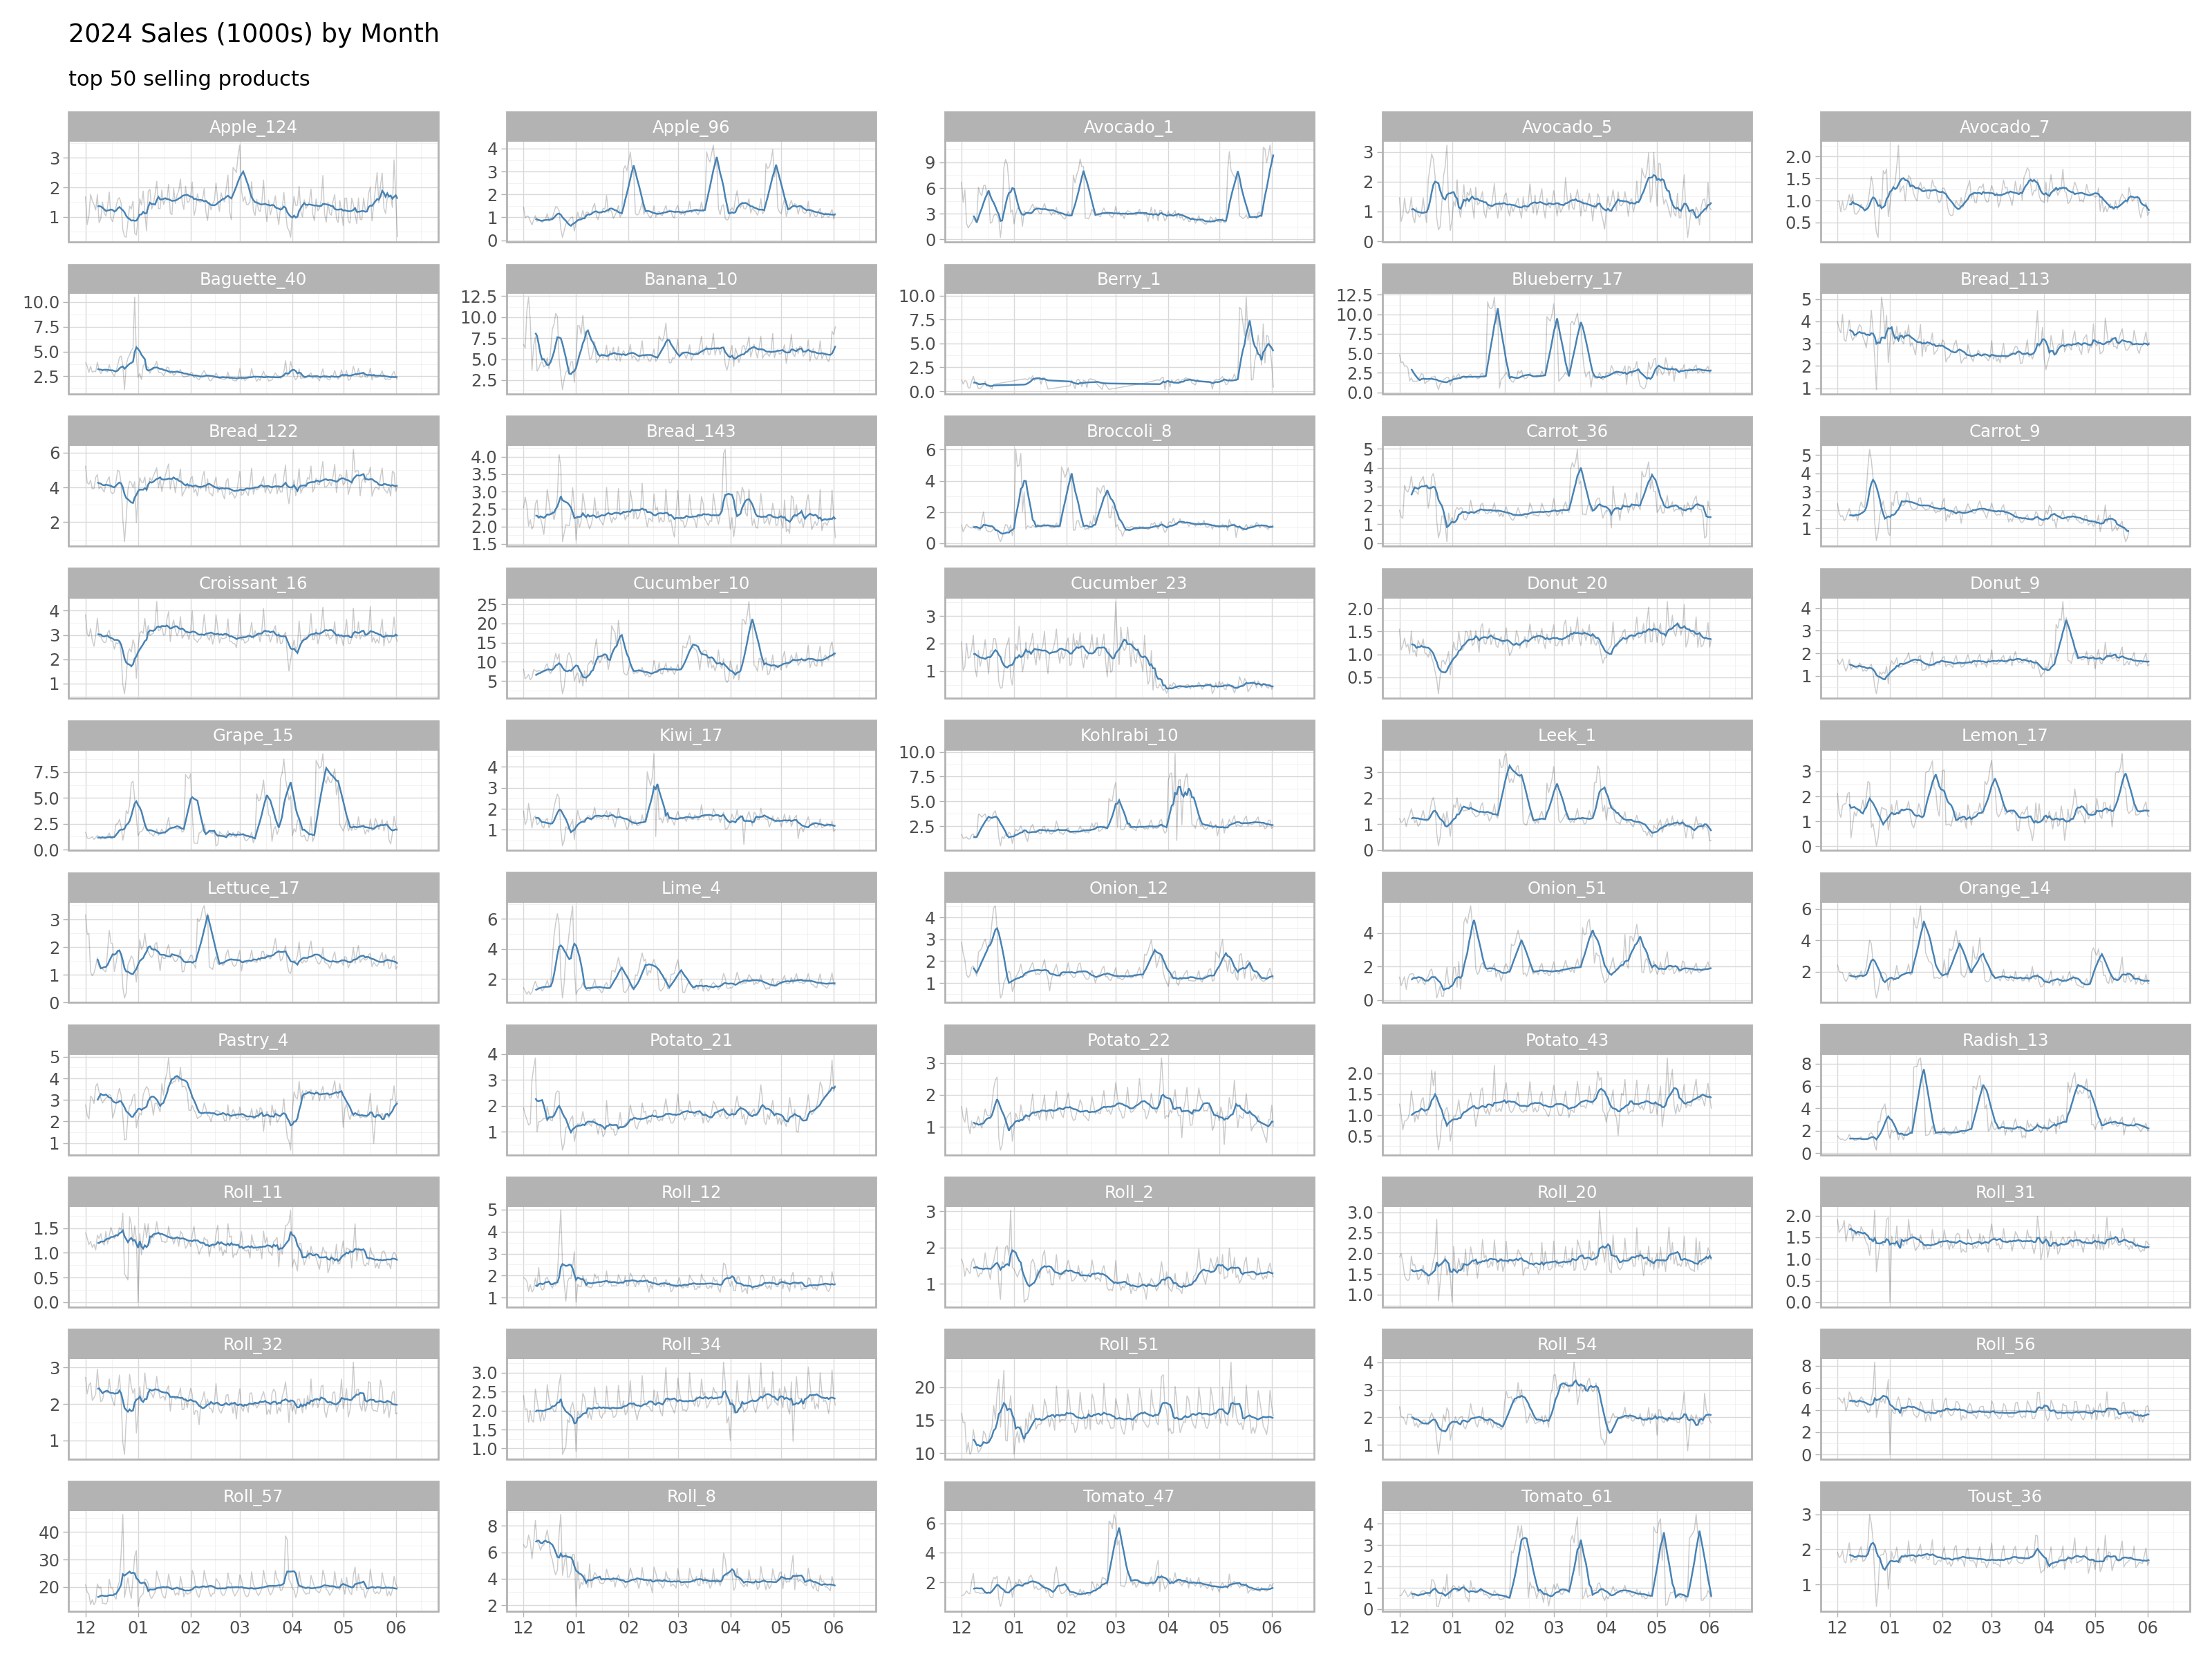

In [10]:
df_warehouse_products = duckdb.query(f'''
    SELECT 
       name, date, 
       count(distinct product_unique_id) as product_count,
       sum(sales) as sales
    FROM 
        all_data
    WHERE
       date >= '2023-12-01'
       and name in (select name from df_top_products)
    GROUP BY name, date
    ''').df()

display(
    ggplot(df_warehouse_products, mapping=aes(x='date', y='sales / 1000')) 
    + theme_light()
    + theme(figure_size=(16, 12))
    + geom_line(size=0.3, alpha=0.2)
    + scale_x_datetime(
        breaks=date_breaks("1 months"), labels=date_format("%m"))
    + facet_wrap('name', ncol=5, scales='free_y')
    + geom_smooth(
        method='mavg', method_args={'window': 7}, 
        color='steelblue', se=False, size=0.5)
    + labs(x='', y='', 
        title='2024 Sales (1000s) by Month',
        subtitle='top 50 selling products'))

# Fit Model

In [11]:
# add groupings for previous weeks:

groupings = ['l1_cat', 'l2_cat', 'l3_cat', 'l4_cat', 'name']
for grouping in groupings:
    # without warehouse
    duckdb.query(f'''
        create or replace table {grouping}_hist as
        select dt_fold, {grouping}, mean(sales) as sales
        from all_data
        where dt_fold > 0
        group by dt_fold, {grouping}
        having sum(sales) is not null
        order by dt_fold, {grouping}''')
    # with warehouse
    duckdb.query(f'''
        create or replace table {grouping}_whist as
        select dt_fold, warehouse, {grouping}, mean(sales) as sales, stddev(sales) as sales_sd,
        from all_data
        where dt_fold > 0
        group by dt_fold, warehouse, {grouping}
        having sum(sales) is not null
        order by dt_fold, {grouping}''')

# same day:
duckdb.query(f'''
    create or replace table name_whist_day as
    select dt_fold, dt_fold_day, warehouse, name, sum(sales) as sales
    from all_data
    where dt_fold > 0
    group by dt_fold, dt_fold_day, warehouse, name
    having sum(sales) is not null
    order by dt_fold, warehouse, name''')

In [12]:
duckdb.query(f'''
    create or replace table fe_data as
    select 
        a.*,
        -- sales of similar products in previous fortnight.
        -- overall
        coalesce(l1_cat_hist.sales, 0) as l1_cat_m1,
        coalesce(l2_cat_hist.sales, 0) as l2_cat_m1,
        coalesce(l3_cat_hist.sales, 0) as l3_cat_m1,
        coalesce(l4_cat_hist.sales, 0) as l4_cat_m1,
        coalesce(name_hist.sales, 0) as name_m1,
        -- by warehouse
        coalesce(l1_cat_whist.sales, 0) as l1_cat_wm1,
        coalesce(l2_cat_whist.sales, 0) as l2_cat_wm1,
        coalesce(l3_cat_whist.sales, 0) as l3_cat_wm1,
        coalesce(l4_cat_whist.sales, 0) as l4_cat_wm1,
        -- name & warehouse last 3
        coalesce(m1.sales, 0) as name_wm1,
        coalesce(m1.sales_sd, 0) as name_sd_wm1,
        coalesce(m2.sales, 0) as name_wm2,
        coalesce(m3.sales, 0) as name_wm3,
        coalesce(m4.sales, 0) as name_wm4,
        coalesce(m5.sales, 0) as name_wm5,
        (coalesce(m1.sales, 0) * 1
         + coalesce(m2.sales, 0) * 0.8
         + coalesce(m3.sales, 0) * 0.6
         + coalesce(m4.sales, 0) * 0.3
         + coalesce(m5.sales, 0) * 0.1 ) as name_w_weighted,
        coalesce(name_whist_day.sales, 0) as day_sales_m1,
        extract(dayofweek FROM date) AS day_of_week, 
        extract(month FROM date) AS month, 
        extract(day FROM date) AS day_of_month,
        extract(year FROM date) as year,
        extract(dayofyear FROM date) as day_of_year,
        extract(week FROM date) as week_no,
    from 
        all_data a
        -- overall all warehouses:
        left join l1_cat_hist 
            on l1_cat_hist.dt_fold + 1 = a.dt_fold 
                and l1_cat_hist.l1_cat = a.l1_cat
        left join l2_cat_hist 
            on l2_cat_hist.dt_fold + 1 = a.dt_fold 
                and l2_cat_hist.l2_cat = a.l2_cat
        left join l3_cat_hist 
            on l3_cat_hist.dt_fold + 1 = a.dt_fold 
                and l3_cat_hist.l3_cat = a.l3_cat
        left join l4_cat_hist 
            on l4_cat_hist.dt_fold + 1 = a.dt_fold 
                and l4_cat_hist.l4_cat = a.l4_cat
        left join name_hist 
            on name_hist.dt_fold + 1 = a.dt_fold 
                and name_hist.name = a.name
        -- by warehouse
        left join l1_cat_whist 
            on l1_cat_whist.dt_fold + 1 = a.dt_fold 
                and l1_cat_whist.warehouse = a.warehouse 
                and l1_cat_whist.l1_cat = a.l1_cat
        left join l2_cat_whist
            on l2_cat_whist.dt_fold + 1 = a.dt_fold 
                and l2_cat_whist.warehouse = a.warehouse 
                and l2_cat_whist.l2_cat = a.l2_cat
        left join l3_cat_whist 
            on l3_cat_whist.dt_fold + 1 = a.dt_fold 
                and l3_cat_whist.warehouse = a.warehouse 
                and l3_cat_whist.l3_cat = a.l3_cat
        left join l4_cat_whist 
            on l4_cat_whist.dt_fold + 1 = a.dt_fold 
                and l4_cat_whist.warehouse = a.warehouse 
                and l4_cat_whist.l4_cat = a.l4_cat
        left join name_whist as m1 
            on m1.dt_fold + 1 = a.dt_fold 
                and m1.warehouse = a.warehouse 
                and m1.name = a.name
        left join name_whist as m2 
            on m2.dt_fold + 2 = a.dt_fold 
                and m2.warehouse = a.warehouse 
                and m2.name = a.name
        left join name_whist as m3 
            on m3.dt_fold + 3 = a.dt_fold 
                and m3.warehouse = a.warehouse 
                and m3.name = a.name
        left join name_whist as m4 
            on m4.dt_fold + 4 = a.dt_fold 
                and m4.warehouse = a.warehouse 
                and m4.name = a.name
        left join name_whist as m5 
            on m5.dt_fold + 5 = a.dt_fold 
                and m5.warehouse = a.warehouse 
                and m5.name = a.name
        left join name_whist_day 
            on name_whist_day.dt_fold + 1 = a.dt_fold
                and name_whist_day.dt_fold_day = a.dt_fold_day
                and name_whist_day.warehouse = a.warehouse 
                and name_whist_day.name = a.name
    where
        a.dt_fold > 2
''')

In [13]:
TARGET_NAME = 'sales'

cat_features =  [
    'warehouse',
    'name', 
    'l1_cat', 
    'l2_cat',
    'l3_cat', 
    'l4_cat',
    'day_of_week', 'month', 'year',
]

features = [
    'warehouse', 'total_orders',
    'sell_price_main', 'type_0_discount', 'type_1_discount',
    'type_2_discount', 'type_3_discount', 'type_4_discount',
    'type_5_discount', 'type_6_discount',  
    'holiday',
    'shops_closed', 
    'days_to_holiday',
    'days_to_shops_closed', 'day_after_closing', 'long_weekend', 'school',
    'name', 
    'l1_cat', 
    'l2_cat',
    'l3_cat', 
    'l4_cat',
    #'l1_cat_m1', 'l2_cat_m1', 'l3_cat_m1', 
    'l4_cat_m1', 'name_m1', 
    #'l1_cat_wm1', 'l2_cat_wm1', 'l3_cat_wm1', 
    'l4_cat_wm1', 
    'name_wm1', 'name_sd_wm1',
    'name_wm2', 'name_wm3', 'name_wm4', 'name_wm5', 'name_w_weighted',
    'day_sales_m1',
    'day_of_week', 'month', 'day_of_month', 'year',
    'day_of_year', 'sin_dayofyear', 'cos_dayofyear',
    'week_no',        
]

In [14]:
all_data = duckdb.query(f'''
    select * from fe_data''').df()

all_data[cat_features] = all_data[cat_features].astype('category')

all_data['sin_dayofyear']=np.sin(2 * np.pi * all_data['day_of_year'] / 365)
all_data['cos_dayofyear']=np.cos(2 * np.pi * all_data['day_of_year'] / 365)

ts = all_data.query('rowtype == "test"')
tr = all_data.query('rowtype == "train" and dt_fold < 97')
vl = all_data.query('rowtype == "train" and dt_fold >= 97')


del all_data
gc.collect()

ts.shape, tr.shape, vl.shape

((47021, 57), (3759180, 57), (190794, 57))

Naive baseline - use the prior 2 weeks:


Each Out of sample fortnight is a two week period - hopefully we can do much better.

In [15]:
for fold in sorted(vl['dt_fold'].unique()):
    fl = vl.query('dt_fold == @fold')
    fold_metric = metrics.mean_absolute_error(fl[TARGET_NAME], fl['name_wm1'], sample_weight=fl['weight'])
    print(f'Out of sample fortnight: {fold} metric: {fold_metric:3.4f}')

Out of sample fortnight: 97 metric: 30.2051
Out of sample fortnight: 98 metric: 32.5799
Out of sample fortnight: 99 metric: 34.5443
Out of sample fortnight: 100 metric: 32.7728


In [16]:
def fit_model(cls, params, tr, vl, ts=None):
    global shap_values, shap_vl
    model = cls(**params)

    callbacks = [lgb.log_evaluation(period=20)]
    model.fit(
        X=tr[features], y = tr[TARGET_NAME], sample_weight=tr['weight'],
        eval_set=[(vl[features], vl[TARGET_NAME])],
        eval_sample_weight=[vl['weight']],
        callbacks=callbacks
    )
    
    vl_preds = np.clip((model.predict(vl[features])), 0, np.inf)
    ts_preds = None
    if ts is not None:
        ts_preds = np.clip((model.predict(ts[features])), 0, np.inf)
    
    if shap_values is None:
        # Calculate shap values on first model, first fold:
        if len(vl) > 50_000:
            shap_vl = vl.copy().sample(n=50_000)
        else:
            shap_vl = vl.copy()
        shap_values = shap.TreeExplainer(model).shap_values(shap_vl[features])
        pass
    
    return vl_preds, ts_preds

In [17]:
shap_values = None
shap_vl = None

params = {
 'learning_rate': 0.05,
 'max_depth': 10,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'num_boost_round': 11000,
 'early_stopping_rounds': 500,
 'objective': 'regression',
 'metric': 'mae',
 'boosting_type': 'gbdt',
 'max_bin': 3000,
 'random_seed': 2112,
 'verbose':  -1}

vl_preds, ts_preds = fit_model(lgb.LGBMRegressor, params, tr, vl, ts)

[20]	valid_0's l1: 36.6594
[40]	valid_0's l1: 27.1793
[60]	valid_0's l1: 24.2433
[80]	valid_0's l1: 22.8809
[100]	valid_0's l1: 22.2005
[120]	valid_0's l1: 21.7751
[140]	valid_0's l1: 21.4915
[160]	valid_0's l1: 21.277
[180]	valid_0's l1: 21.151
[200]	valid_0's l1: 21.0137
[220]	valid_0's l1: 20.9345
[240]	valid_0's l1: 20.8381
[260]	valid_0's l1: 20.76
[280]	valid_0's l1: 20.6608
[300]	valid_0's l1: 20.62
[320]	valid_0's l1: 20.5732
[340]	valid_0's l1: 20.5391
[360]	valid_0's l1: 20.5051
[380]	valid_0's l1: 20.4714
[400]	valid_0's l1: 20.4255
[420]	valid_0's l1: 20.3944
[440]	valid_0's l1: 20.3898
[460]	valid_0's l1: 20.3727
[480]	valid_0's l1: 20.3383
[500]	valid_0's l1: 20.3187
[520]	valid_0's l1: 20.306
[540]	valid_0's l1: 20.2873
[560]	valid_0's l1: 20.2517
[580]	valid_0's l1: 20.2139
[600]	valid_0's l1: 20.1942
[620]	valid_0's l1: 20.1737
[640]	valid_0's l1: 20.1644
[660]	valid_0's l1: 20.1627
[680]	valid_0's l1: 20.1583
[700]	valid_0's l1: 20.1417
[720]	valid_0's l1: 20.1168
[74

### How we doing?

In [18]:
print('Out of sample Predictions by fortnight')
df_preds = vl.copy().assign(pred = vl_preds)
for fold in sorted(df_preds['dt_fold'].unique()):
    df_fold = df_preds.query('dt_fold == @fold')
    fold_metric = metrics.mean_absolute_error(
        df_fold[TARGET_NAME], df_fold['pred'], sample_weight=df_fold['weight'])
    print(f'Out of sample fortnight: {fold} metric: {fold_metric:3.4f}')

Out of sample Predictions by fortnight
Out of sample fortnight: 97 metric: 17.6431
Out of sample fortnight: 98 metric: 19.3923
Out of sample fortnight: 99 metric: 20.8636
Out of sample fortnight: 100 metric: 20.3692


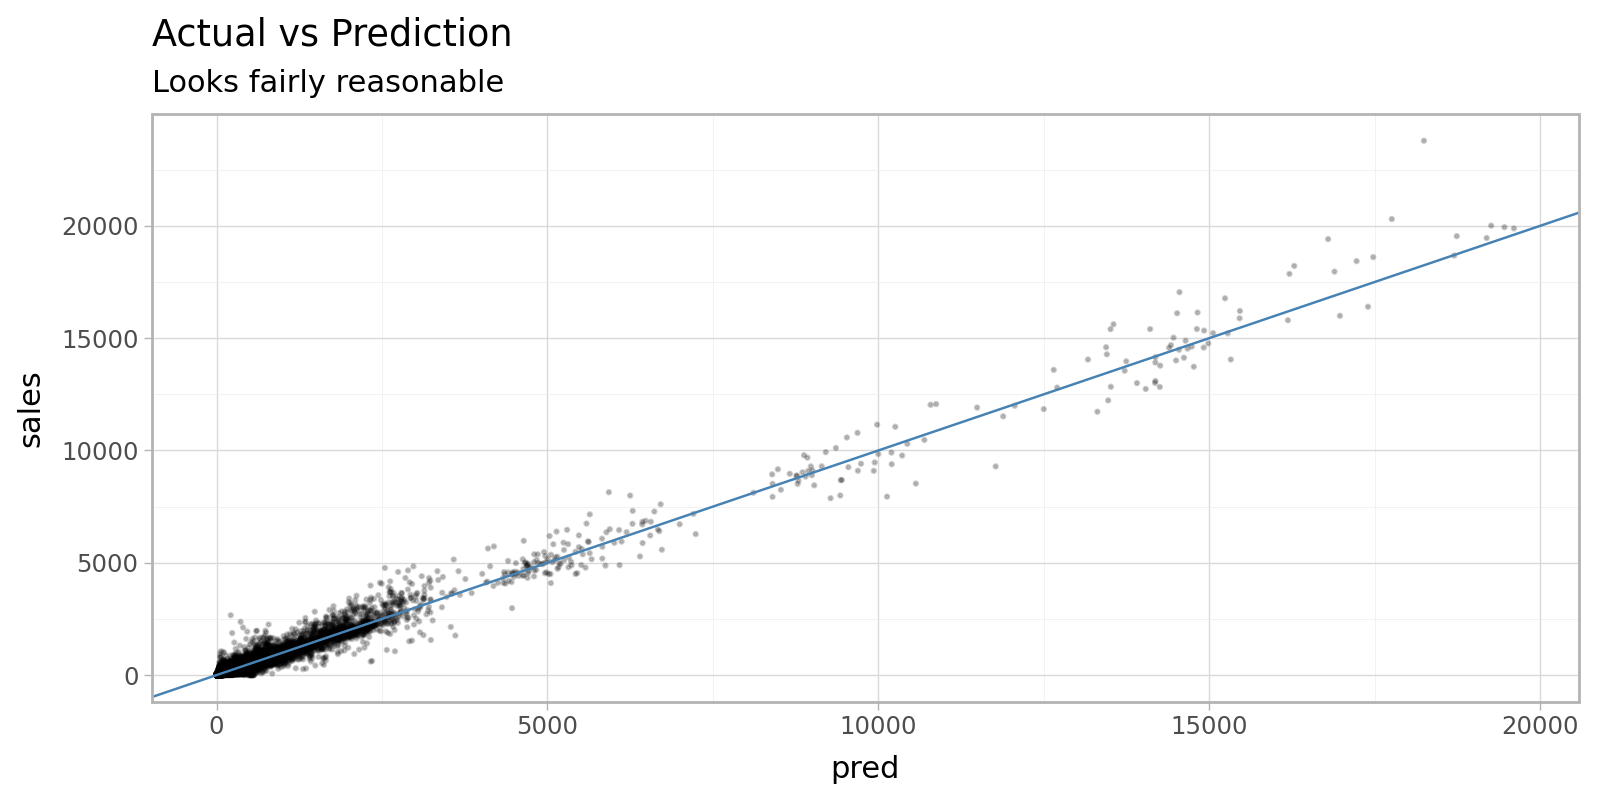

In [19]:
display(
    ggplot(df_preds, mapping=aes(x='pred', y='sales')) 
    + theme_light()
    + theme(figure_size=(8,4))
    + geom_point(size=0.3, alpha=0.2)
    + geom_abline(intercept=0, slope=1, colour='steelblue')
    + labs(title='Actual vs Prediction', 
           subtitle='Looks fairly reasonable')
    #+ scale_x_log10()
    #+ scale_y_log10()
)

### Feature Importance and Partial Dependance based on SHAP

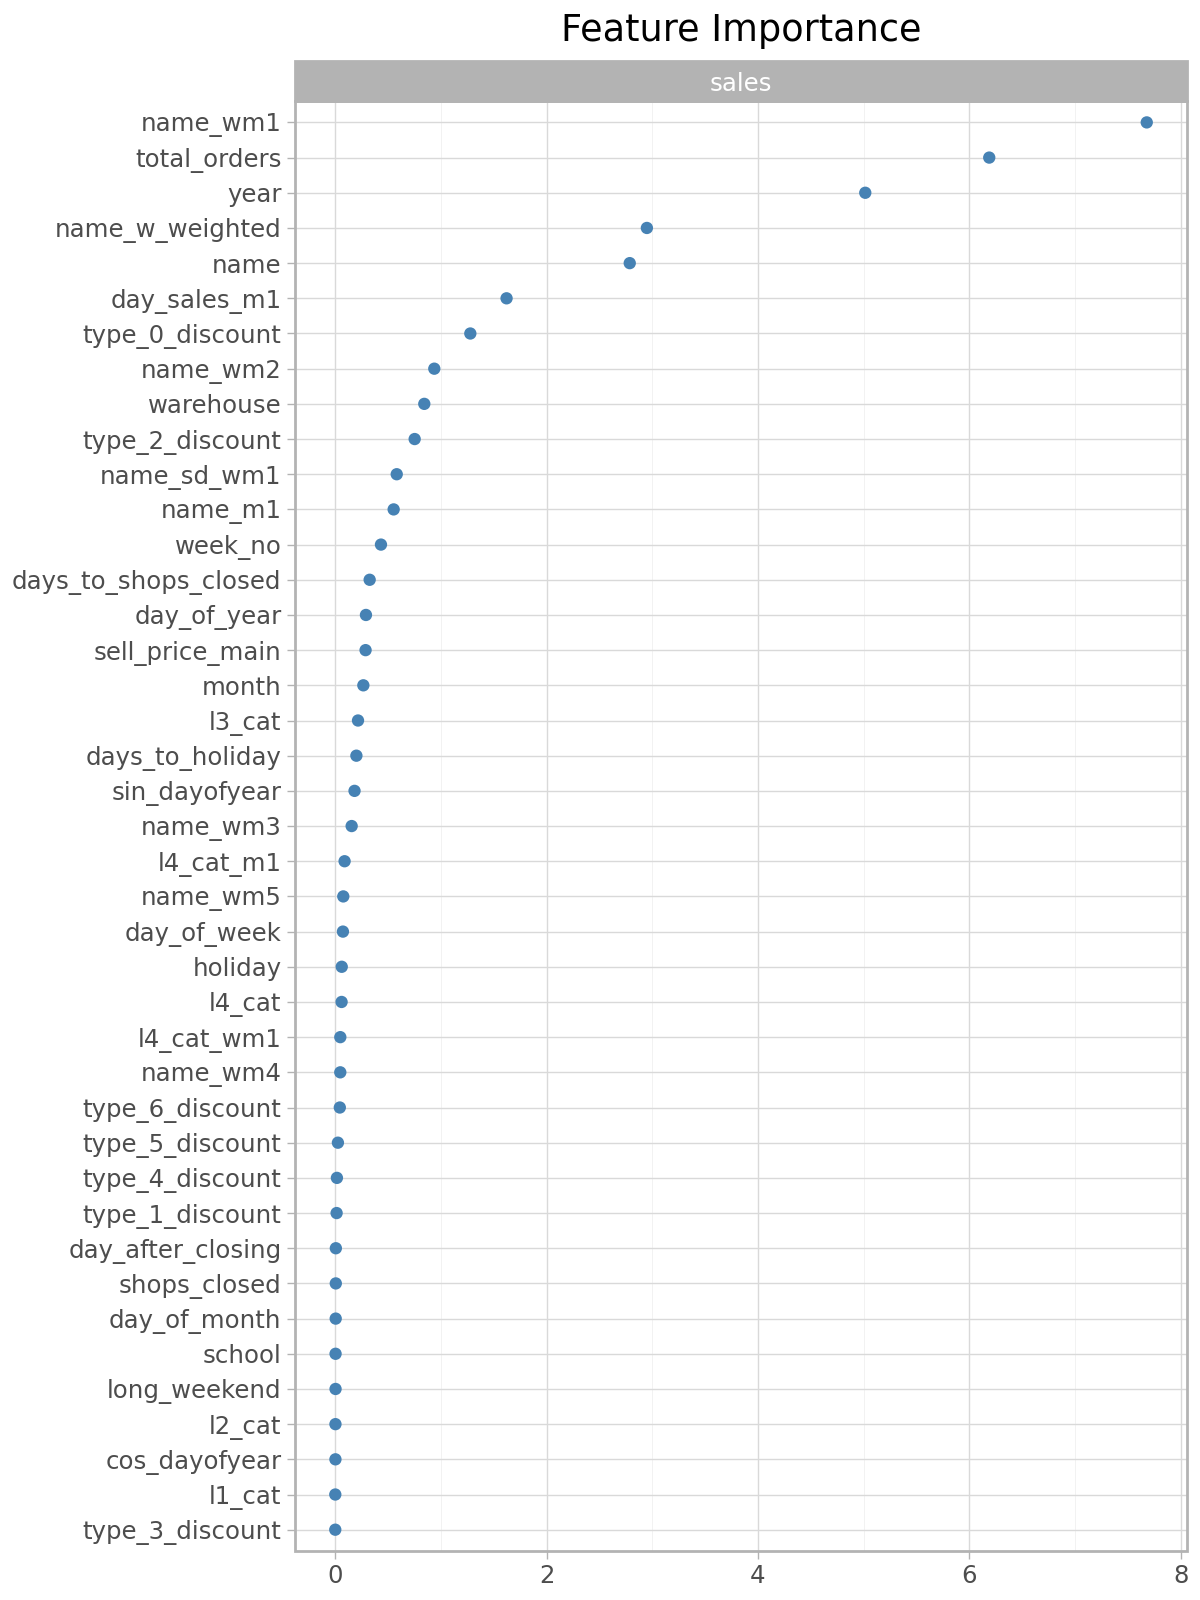

In [20]:
target_map = {TARGET_NAME: 1}
if shap_values is not None:
    df_imp_shap = []
    for target, target_idx in target_map.items():
        shap_df = pd.DataFrame(shap_values, columns = features)
        df_imp_shap.append(pd.DataFrame({
            'target': target,
            'imp': shap_df.mean().abs(),
            'col': shap_df.columns})
            .sort_values(['imp'], ascending=[False]))
    df_imp_shap = pd.concat(df_imp_shap)
    df_imp_shap

    # columns in importance order
    df_imp_shap_col = (
        df_imp_shap
        .groupby(['col'], as_index=False)
        .agg(imp=('imp', 'mean'))
        .sort_values(['imp'], ascending=[True])
        .assign(order = lambda x: np.arange(len(x)))
        .drop(columns=['imp']))

    feature_cat  = pd.Categorical(df_imp_shap['col'], categories=df_imp_shap_col['col'].tolist())

    display(ggplot(df_imp_shap.assign(feature_cat=feature_cat), aes(y='feature_cat', x='imp')) 
            + theme_light()
            + theme(figure_size=(6, 8))
            + geom_point(colour='SteelBlue')
            + labs(y = '', x='', title = f'Feature Importance')
            + facet_wrap('target', ncol=3)
            #+ scale_x_log10()
             )

    most_important = df_imp_shap_col['col'][::-1][:24]

- Top predictor is the average for the same product and warehouse in the previous week.
- The relationship to total orders makes less sense.

Maybe consider smoothing some of the other predictors.

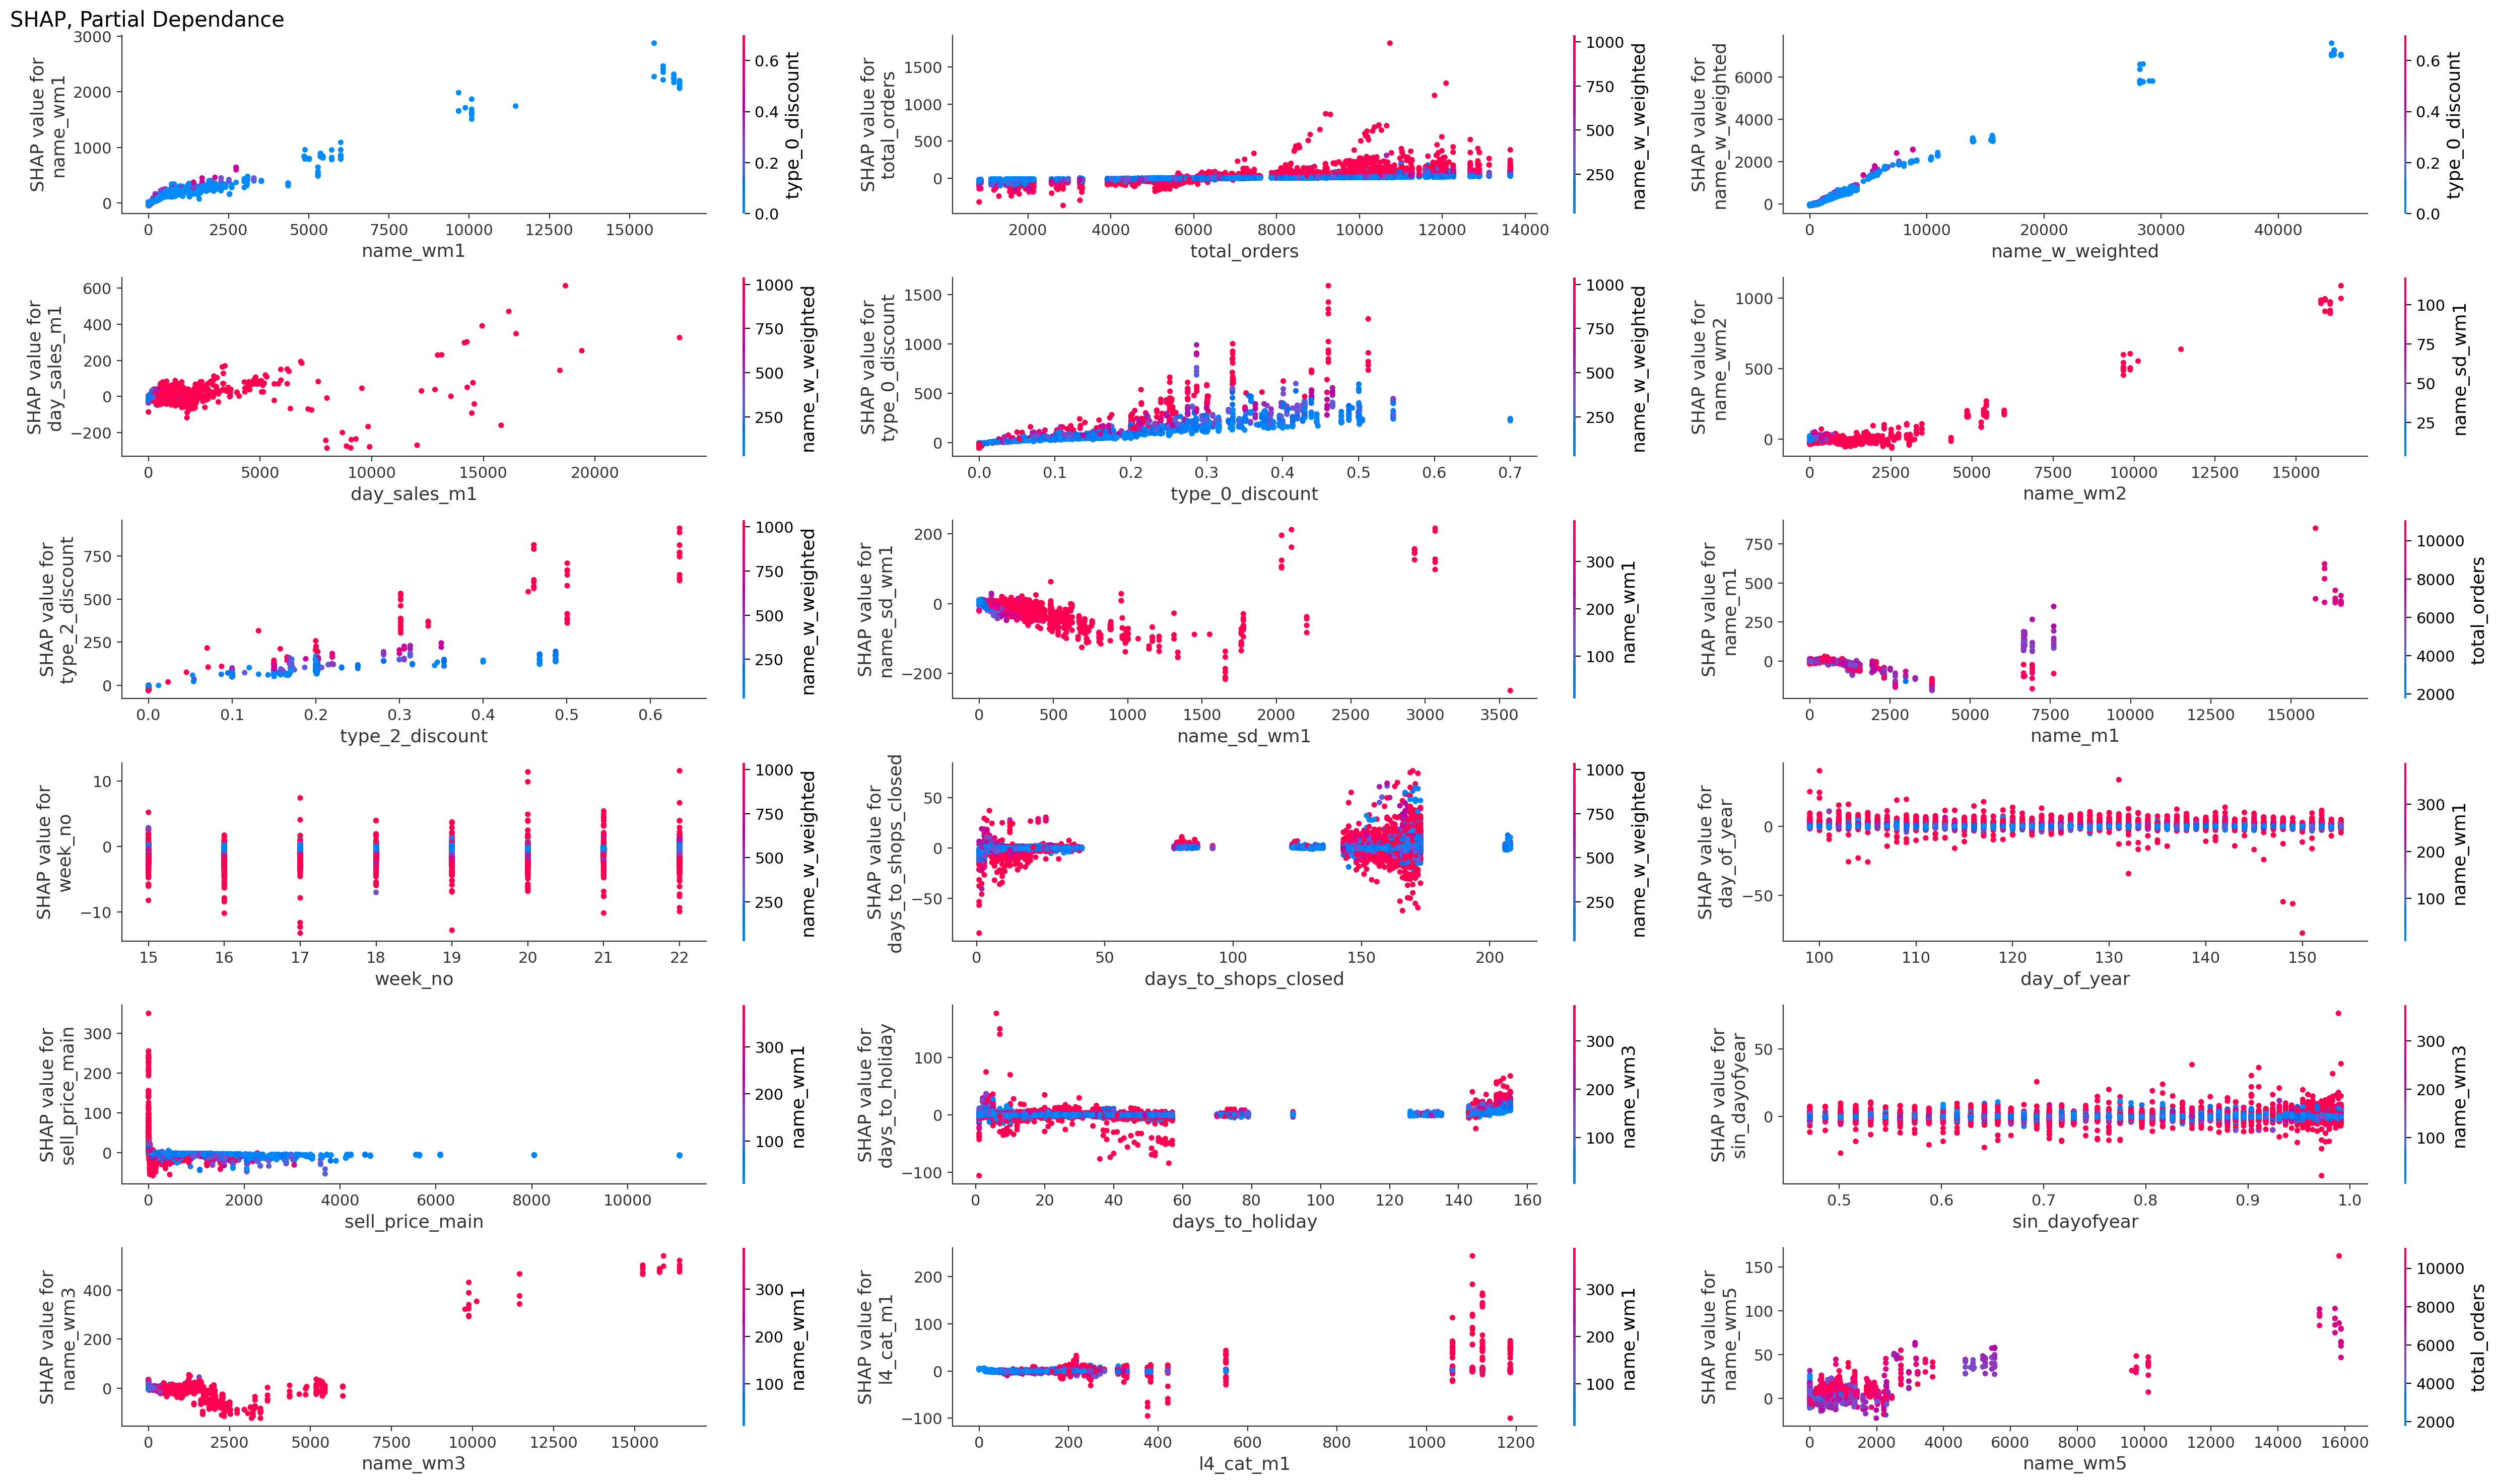

In [21]:
def plot_shap():
    metric_cols = sorted(set(most_important) - set(cat_features), 
                         key=str.casefold)

    N_X = 3
    N_Y = -(-( len(target_map.items()) * len(metric_cols)) // N_X)

    fig, ax = plt.subplots(N_Y, N_X, figsize=(25, 15))
    ax = ax.flatten()

    i = 0
    for _, f in enumerate(most_important):
        if f in cat_features:
            continue
        for status, index in target_map.items():
            shap.dependence_plot(
                f, shap_values, shap_vl[features],
                ax=ax[i], show=False)
            #ax[i].title.set_text(status)
            i += 1

    # remove left-over facets
    for i in range(len(metric_cols) * len(target_map.items()), N_X * N_Y):
        ax[i].remove()

    fig.suptitle(f'SHAP, Partial Dependance', 
            x=0, horizontalalignment='left', fontsize=15)
    fig.subplots_adjust(bottom=0.1)
    plt.tight_layout()

if shap_values is not None:
    plot_shap()

Categorical levels with the largest effects

- picking out the top selling products

In [22]:
def cat_shap(f):
    # extract shap summary for categorial variables
    f_idx = features.index(f)
    df_shap = pd.DataFrame(
        {'value': shap_values[:, f_idx], f: shap_vl[f]})
    return (df_shap
        .groupby(f, as_index=False)
        .agg(
            shap_mean=('value', 'mean'), 
            shap_sd=('value', 'std'))
        .sort_values(['shap_mean'], ascending=[False])
        .rename(columns={f: 'levels'})
        .assign(col=f))

(pd.concat(
    cat_shap(f).query('not shap_mean.isna()')
        for f in cat_features)
    .sort_values(['shap_mean'], ascending=[False])).head(10)

levels    shap_mean     shap_sd   col
2172        Roll_51  1575.421976  181.472248  name
2178        Roll_57   669.451999  125.988656  name
985     Cucumber_27   365.423108   54.998321  name
999      Cucumber_8   324.357507   54.905360  name
2152        Roll_32   296.712122   40.125170  name
2615  Watermelon_17   265.190860  220.036880  name
2175        Roll_54   256.217413   95.074925  name
29        Apple_124   254.041543   84.555726  name
1687       Pastry_4   247.615880   85.885632  name
981     Cucumber_23   233.236153   23.413247  name

### How do our predictions look for the top selling products?

Again, seem very reasonable in the validation period.

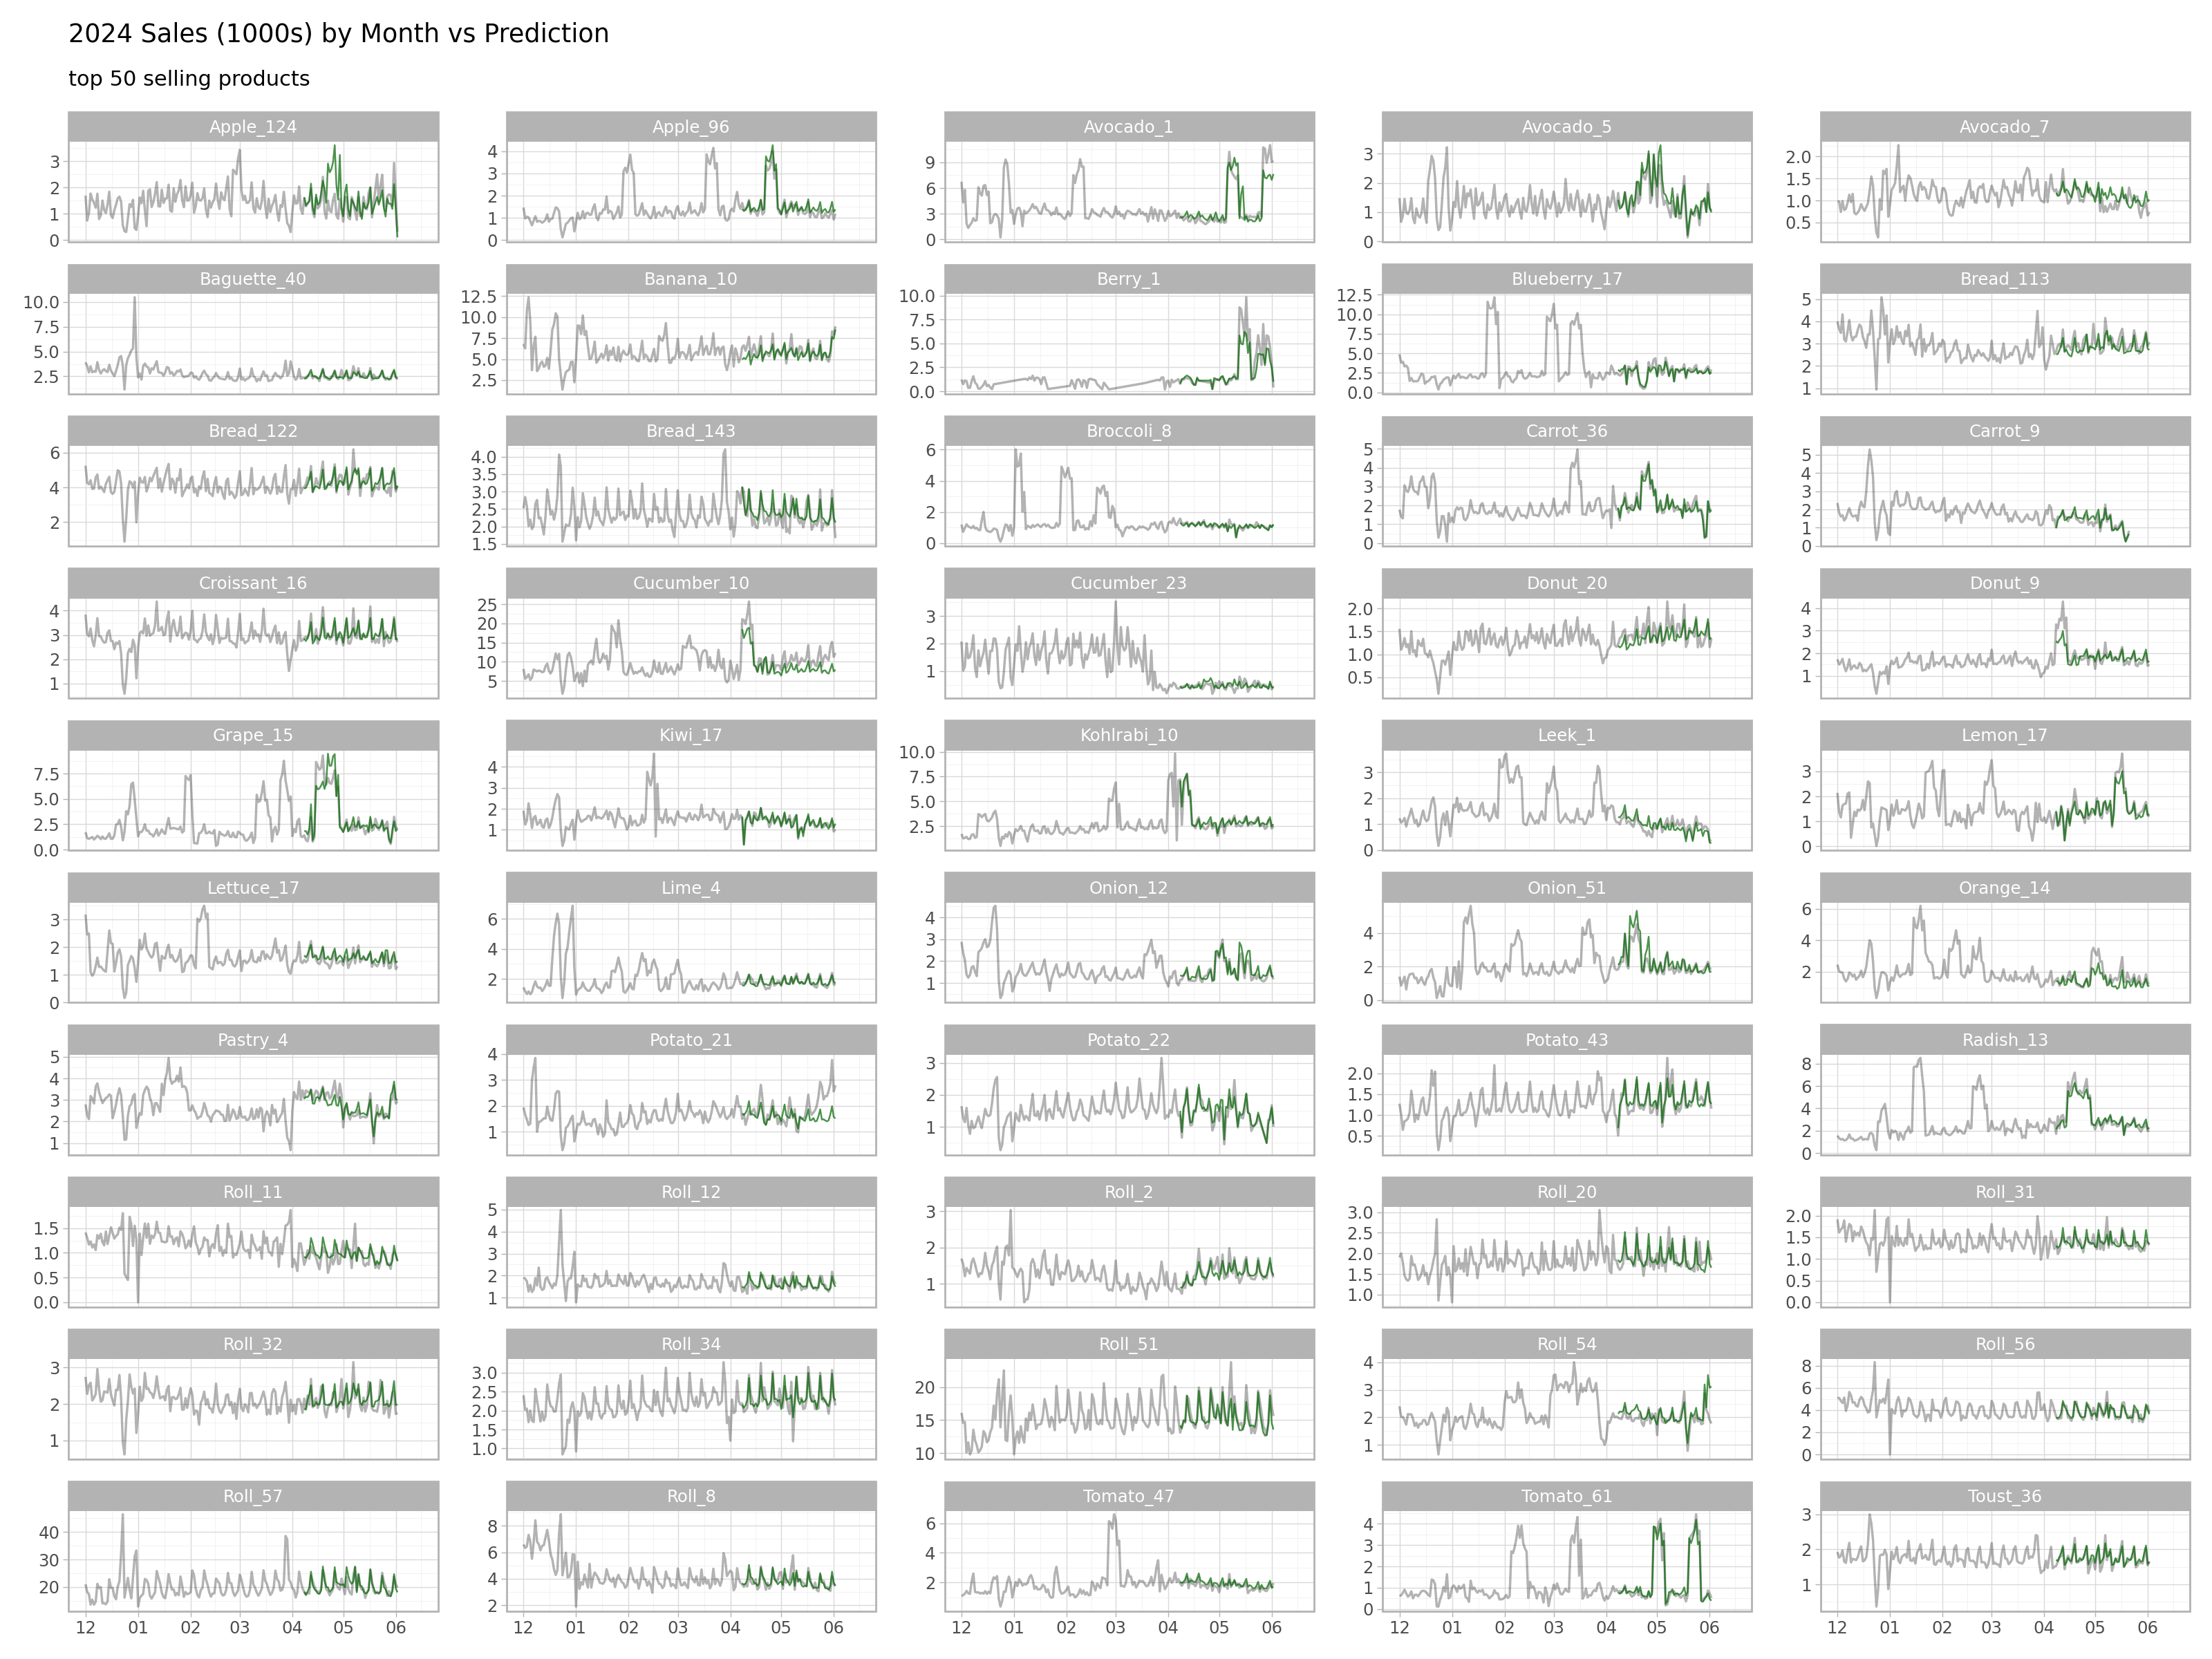

In [23]:
df_warehouse_preds = duckdb.query(f'''
    SELECT 
       name, date, 
       count(distinct product_unique_id) as product_count,
       sum(sales) as sales,
       sum(pred) as pred
    FROM 
        df_preds
    WHERE
       date >= '2024-01-01'
       and name in (select name from df_top_products)
    GROUP BY name, date
    ''').df()


display(
    ggplot(df_warehouse_products, mapping=aes(x='date', y='sales / 1000')) 
    + theme_light()
    + theme(figure_size=(16, 12))
    + geom_line(size=0.7, alpha=0.3)
    + scale_x_datetime(
        breaks=date_breaks("1 months"), labels=date_format("%m"))
    + facet_wrap('name', ncol=5, scales='free_y')
    #+ geom_smooth(
    #    method='mavg', method_args={'window': 7}, 
    #    color='steelblue', se=False, size=0.5)
    + geom_line(
            data=df_warehouse_preds,
            mapping=aes(y='pred / 1000'), 
            colour='darkgreen',
            size=0.5, alpha=0.7)
    + labs(x='', y='', 
        title='2024 Sales (1000s) by Month vs Prediction',
        subtitle='top 50 selling products'))

# Refit and submit.

In [24]:
params_refit = params.copy()
del params_refit['early_stopping_rounds']
params_refit['num_boost_round'] = 7600

# don't trust the validation shown here:
_, ts_preds = fit_model(lgb.LGBMRegressor, params_refit, pd.concat([tr, vl]), vl, ts)

[20]	valid_0's l1: 36.3346
[40]	valid_0's l1: 26.3601
[60]	valid_0's l1: 23.1854
[80]	valid_0's l1: 21.6458
[100]	valid_0's l1: 20.8342
[120]	valid_0's l1: 20.224
[140]	valid_0's l1: 19.8516
[160]	valid_0's l1: 19.5784
[180]	valid_0's l1: 19.3701
[200]	valid_0's l1: 19.1785
[220]	valid_0's l1: 19.0202
[240]	valid_0's l1: 18.8935
[260]	valid_0's l1: 18.7298
[280]	valid_0's l1: 18.5892
[300]	valid_0's l1: 18.4552
[320]	valid_0's l1: 18.3587
[340]	valid_0's l1: 18.2227
[360]	valid_0's l1: 18.114
[380]	valid_0's l1: 18.0202
[400]	valid_0's l1: 17.9297
[420]	valid_0's l1: 17.836
[440]	valid_0's l1: 17.7516
[460]	valid_0's l1: 17.6955
[480]	valid_0's l1: 17.5995
[500]	valid_0's l1: 17.512
[520]	valid_0's l1: 17.4405
[540]	valid_0's l1: 17.372
[560]	valid_0's l1: 17.3016
[580]	valid_0's l1: 17.2484
[600]	valid_0's l1: 17.1664
[620]	valid_0's l1: 17.0726
[640]	valid_0's l1: 17.0509
[660]	valid_0's l1: 16.9838
[680]	valid_0's l1: 16.9376
[700]	valid_0's l1: 16.9021
[720]	valid_0's l1: 16.8439
[

In [25]:
(ts
    .assign(**{
        'sales_hat': ts_preds,
        'id': lambda x: x['unique_id'].astype(str) + "_" + x['date'].astype(str)})
    .sort_values(['unique_id', 'date'])
    .filter(['id', 'sales_hat'])
    .to_csv('submission.csv', index=False))

pd.read_csv('submission.csv').head(100)

id   sales_hat
0    1_2024-06-03  214.414120
1    1_2024-06-04  172.349625
2    1_2024-06-05  175.562710
3    1_2024-06-06  173.279555
4    1_2024-06-07  221.489417
5    1_2024-06-08  150.604843
6    1_2024-06-09  145.242561
7    1_2024-06-10  203.331151
8    1_2024-06-11  160.629427
9    1_2024-06-12  184.624284
10   1_2024-06-13  192.907277
11   1_2024-06-14  212.432253
12   1_2024-06-15  147.210158
13   1_2024-06-16  143.778008
14   2_2024-06-03  299.928915
15   2_2024-06-04  250.998660
16   2_2024-06-05  246.249443
17   2_2024-06-06  276.903981
18   2_2024-06-07  354.057885
19   2_2024-06-08  228.076772
20   2_2024-06-09  228.319984
21   2_2024-06-10  311.541421
22   2_2024-06-11  238.400402
23   2_2024-06-12  237.996519
24   2_2024-06-13  268.974622
25   2_2024-06-14  338.140266
26   2_2024-06-15  245.234259
27   2_2024-06-16  231.507109
28   3_2024-06-03   90.085615
29   3_2024-06-04   86.112414
30   3_2024-06-05   81.833419
31   3_2024-06-06   88.244126
32   3_2024-06-07   94.316956
33   3_2024-06-08   84.786277
34   3_2024-06-09   84.550123
35   3_2024-06-10   89.097812
36   3_2024-06-11   81.990581
37   3_2024-06-12   77.282639
38   3_2024-06-13   88.066054
39   3_2024-06-15   82.595532
40   3_2024-06-16   84.450337
41   7_2024-06-03   31.328218
42   7_2024-06-04   21.699474
43   7_2024-06-05   23.052808
44   7_2024-06-06   32.900220
45   7_2024-06-07   47.537105
46   7_2024-06-08   23.950744
47   7_2024-06-09   11.111341
48   7_2024-06-10   30.985865
49   7_2024-06-11   22.895441
50   7_2024-06-12   24.151383
51   7_2024-06-13   34.155425
52   7_2024-06-14   48.424988
53   7_2024-06-15   24.340582
54   7_2024-06-16   10.194821
55   9_2024-06-03   33.241263
56   9_2024-06-04   33.008754
57   9_2024-06-05   35.290971
58   9_2024-06-06   39.439539
59   9_2024-06-07   46.941203
60   9_2024-06-08   37.710635
61   9_2024-06-09   36.971968
62   9_2024-06-10   36.821883
63   9_2024-06-11   34.535543
64   9_2024-06-12   36.509568
65   9_2024-06-13   37.730169
66   9_2024-06-14   42.798042
67   9_2024-06-15   39.497622
68   9_2024-06-16   34.285830
69  10_2024-06-03   16.409121
70  10_2024-06-04   16.322844
71  10_2024-06-05   17.215053
72  10_2024-06-06   20.055622
73  10_2024-06-07   23.660892
74  10_2024-06-08   20.458364
75  10_2024-06-09   18.527559
76  10_2024-06-10   17.971575
77  10_2024-06-11   16.556769
78  10_2024-06-12   17.597096
79  10_2024-06-13   19.374785
80  10_2024-06-14   22.200997
81  10_2024-06-15   19.937451
82  10_2024-06-16   18.913020
83  11_2024-06-03   22.202430
84  11_2024-06-04   23.444516
85  11_2024-06-05   24.038399
86  11_2024-06-06   25.580369
87  11_2024-06-07   31.126878
88  11_2024-06-08   29.486046
89  11_2024-06-09   25.333292
90  11_2024-06-10   24.184343
91  11_2024-06-11   22.542079
92  11_2024-06-12   23.880227
93  11_2024-06-13   28.890913
94  11_2024-06-14   30.643771
95  11_2024-06-15   28.005295
96  11_2024-06-16   25.338395
97  12_2024-06-03   36.229731
98  12_2024-06-04   39.360536
99  12_2024-06-05   40.225044